# v1nyl

In [1]:
import os
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import h5py as h5
import data_utils as du

def plot_time_step(slice1, slice2):
	slice1 = slice1.transpose(1,0)
	slice2 = slice2.transpose(1,0)
	plt.figure()
	a = plt.subplot(2,2,1)
	plt.imshow(np.abs(slice1[:,:]), cmap='gray')
	a.set_title("t")
	a = plt.subplot(2,2,2)
	plt.imshow(np.abs(slice2[:,:]), cmap='gray')
	a.set_title("t+1")
	plt.show()

/home/noodles/.conda/envs/turntable/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
num_train, num_val, num_test = 70, 10, 20

train_data,val_data,test_data = du.create_dicts(num_train, num_val, num_test)

(1360, 224, 192)
(1360, 224, 192)


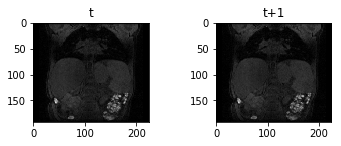

In [3]:
fc = h5.File('datasets/train_curr.h5', 'r')
fn = h5.File('datasets/train_next.h5', 'r')
print(fc[train_data[0]].shape)
print(fn[train_data[0]].shape)
plot_time_step(fc[train_data[0]][510], fn[train_data[0]][510])